In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [1]:
pip install xgboost

     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/70.9 MB 2.4 MB/s eta 0:00:30
     ---------------------------------------- 0.7/70.9 MB 6.9 MB/s eta 0:00:11
     - -------------------------------------- 2.3/70.9 MB 16.5 MB/s eta 0:00:05
     -- ------------------------------------- 4.6/70.9 MB 24.2 MB/s eta 0:00:03
     ----- ---------------------------------- 9.7/70.9 MB 41.3 MB/s eta 0:00:02
     ------ -------------------------------- 11.0/70.9 MB 65.2 MB/s eta 0:00:01
     --------- ----------------------------- 16.5/70.9 MB 93.0 MB/s eta 0:00:01
     ----------- --------------------------- 21.1/70.9 MB 93.9 MB/s eta 0:00:01
     ------------- ------------------------- 24.4/70.9 MB 81.8 MB/s eta 0:00:01
     --------------- ----------------------- 27.6/70.9 MB 81.8 MB/s eta 0:00:01
     ---------------- ---------------------- 30.9/70.9 MB 65.6 MB/s eta 0:00:01
     ------------------ -------------------- 34.2/

In [2]:
import xgboost as xgb

In [22]:
df = pd.read_csv('../Datasets/USEC/PJME_hourly.csv')
df = df.set_index('Datetime')
# cast to datetime as it was being identified as an object
df.index = pd.to_datetime(df.index)

In [16]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


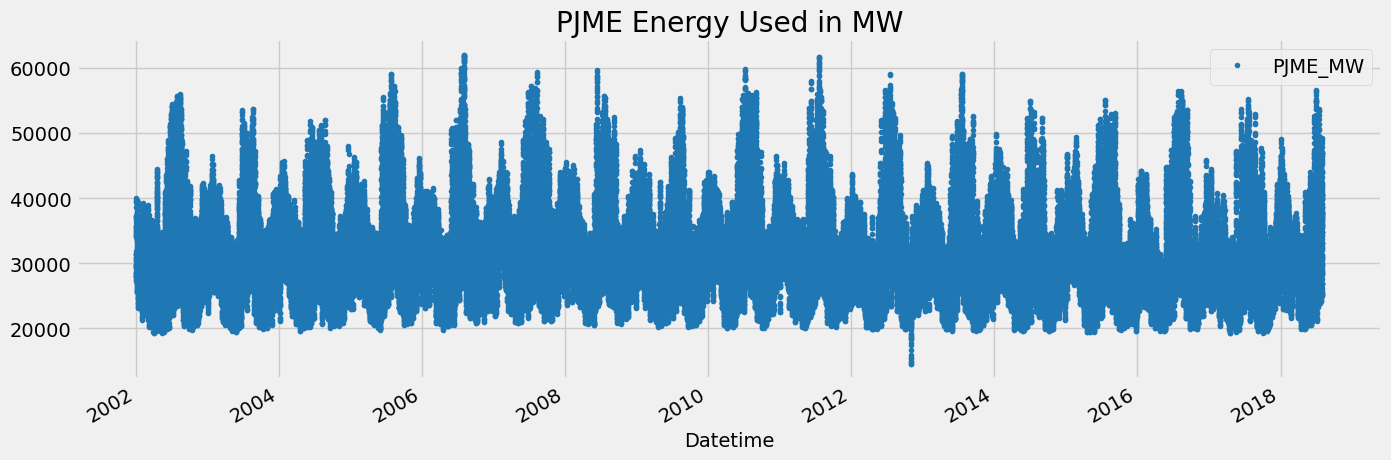

In [24]:
df.plot(style='.', 
        figsize=(15, 5), 
        color=color_pal[0], 
        title= 'PJME Energy Used in MW')
plt.show()

<h2> Test / Train Split

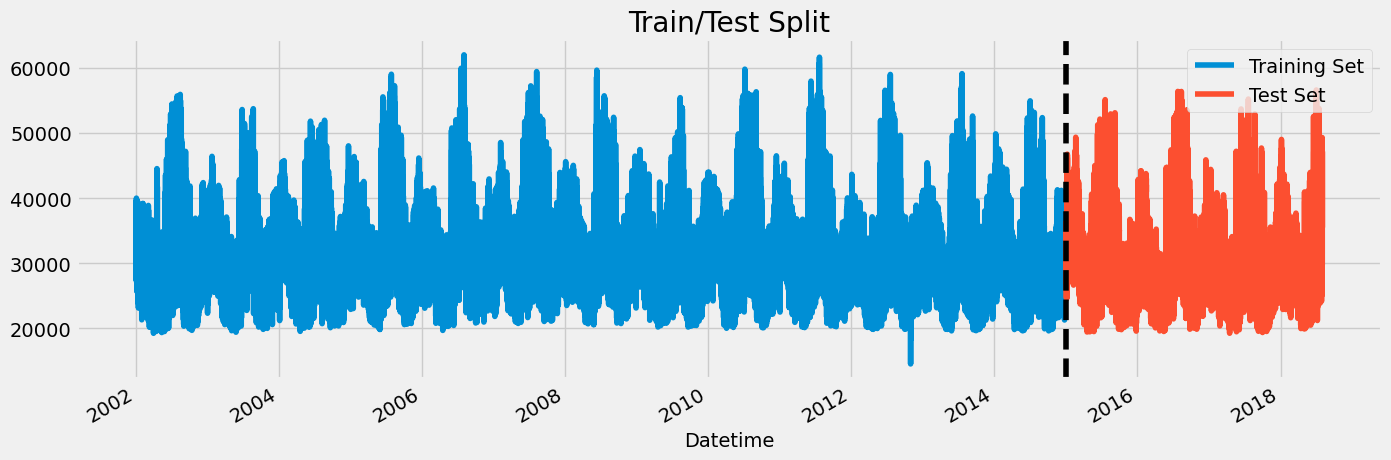

In [49]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#subplot

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title='Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline(x=pd.to_datetime('01-01-2015'), color='black', ls= '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

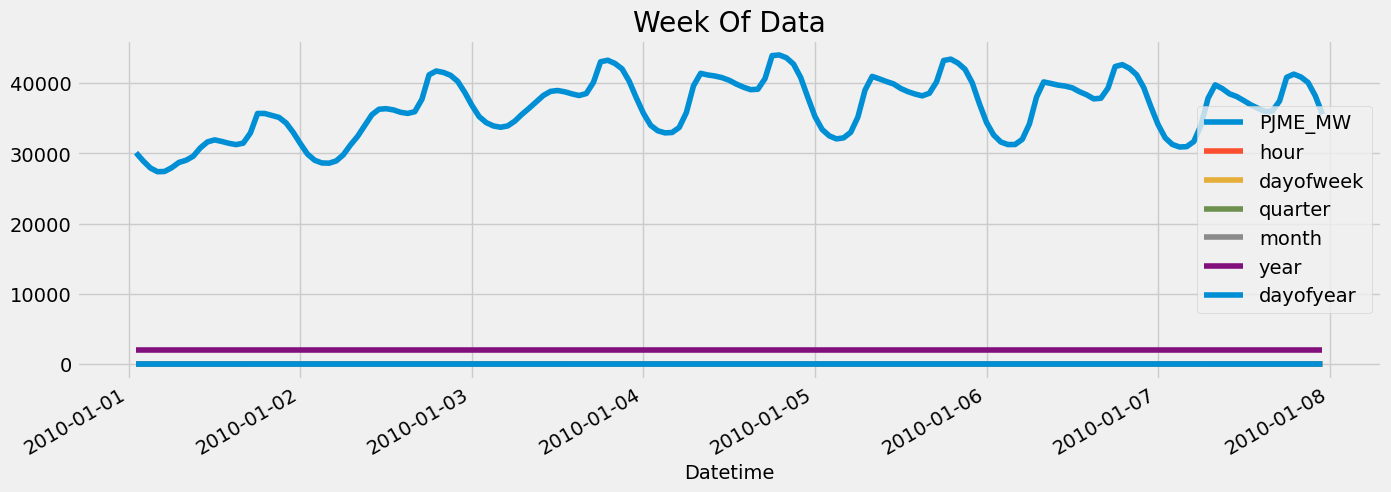

In [71]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

<h2> Feature Creation

In [78]:
def creat_features(df):
    """
    Create Time Series Features based on time series index.

    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


In [61]:
df = creat_features(df)

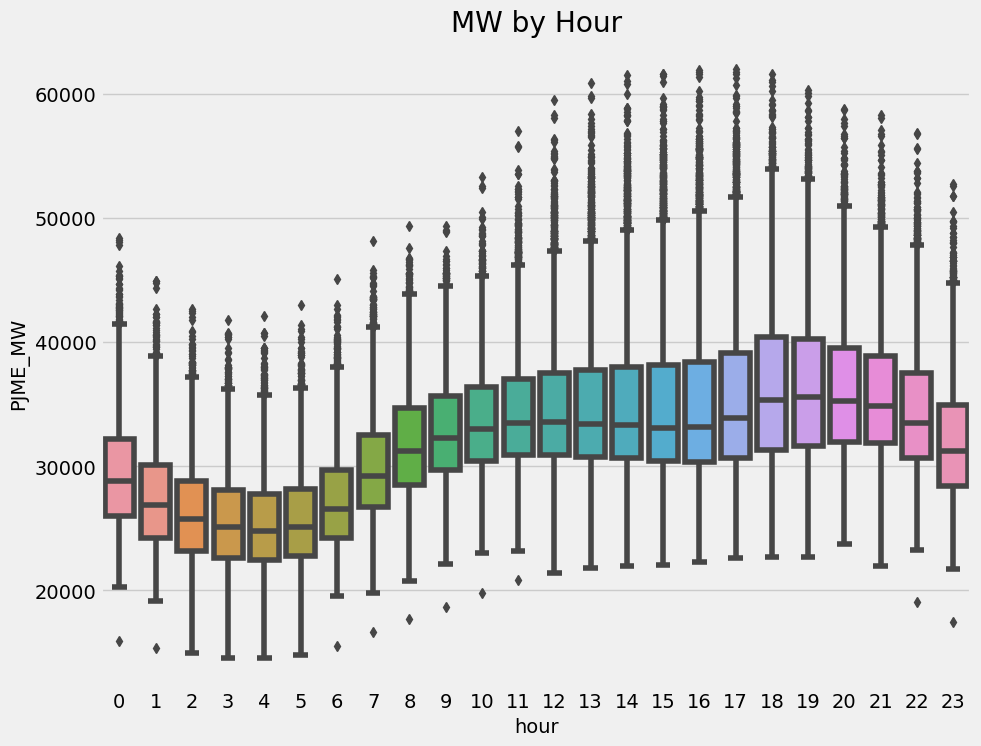

In [70]:
#visulize the features to targets relationships

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

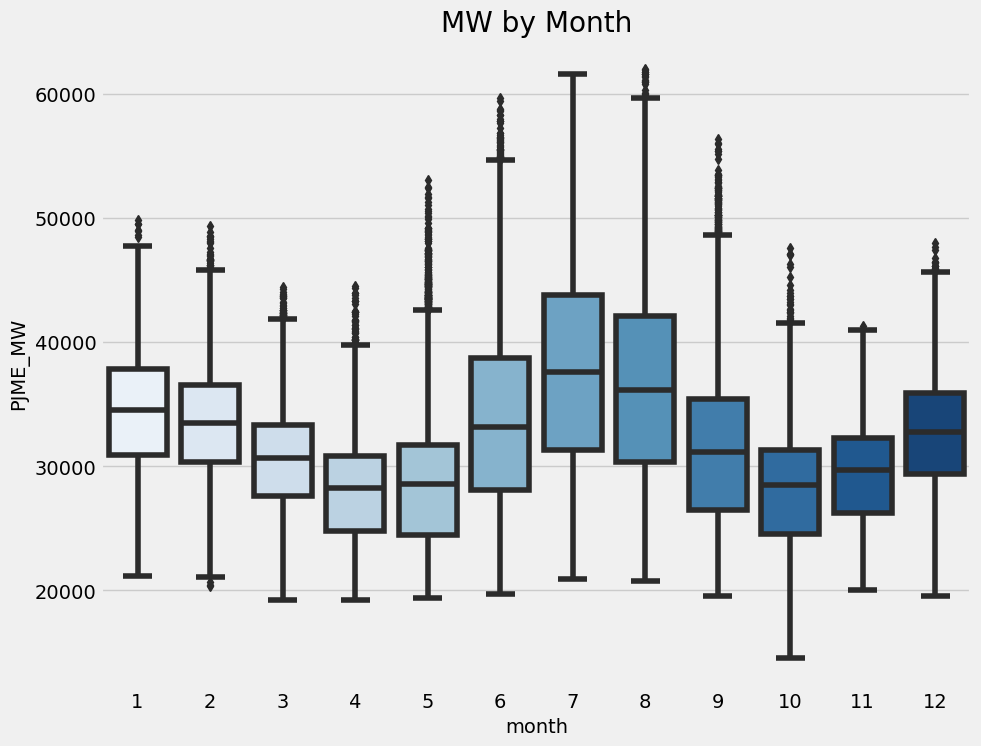

In [76]:
#visulize the features to targets relationships

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create Model

In [79]:
#run train and test model through feat func

train = creat_features(train)
test  = creat_features(test)

In [80]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [81]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'PJME_MW'

In [82]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [88]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set =[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [89]:
fi = pd.DataFrame(data= reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

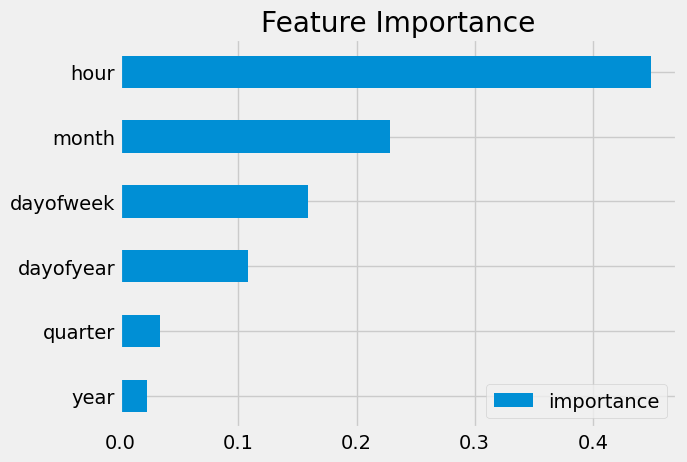

In [91]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [92]:
test['prediction'] = reg.predict(X_test)

In [93]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


In [94]:
df = df.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)

In [96]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40829.566406
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40358.277344
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39135.480469


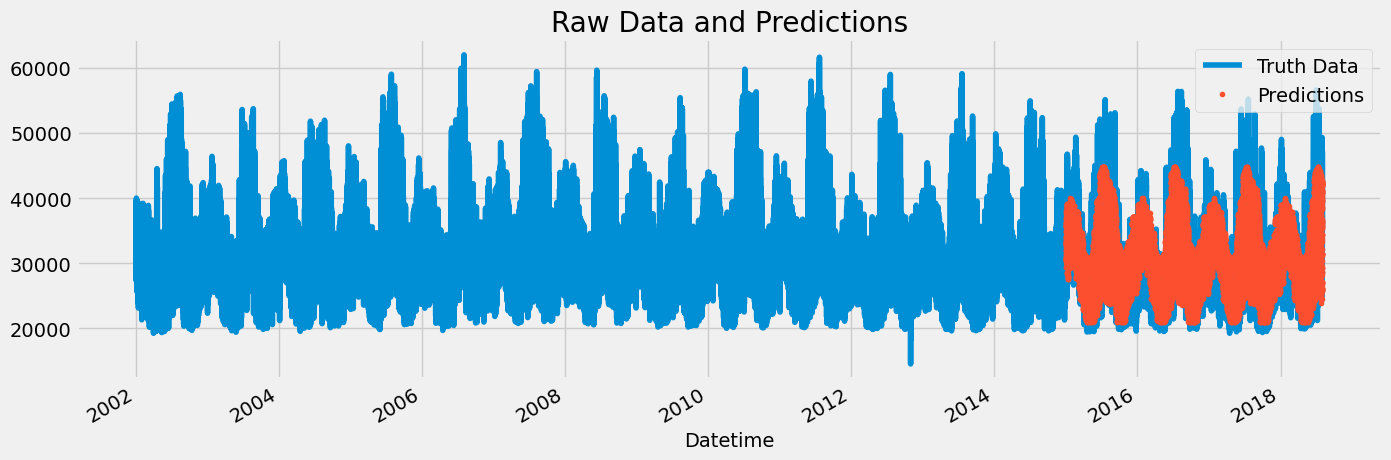

In [98]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize= (15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

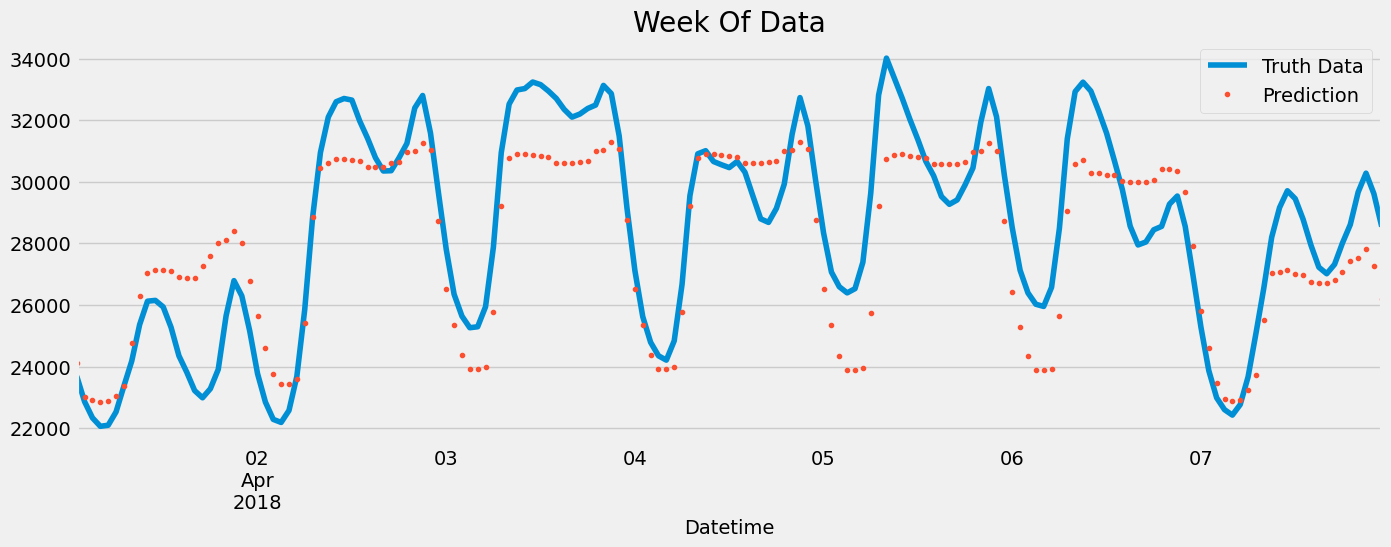

In [102]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [105]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

In [106]:
score

3715.9314164142415

In [108]:
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


In [110]:
#calculate error
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [112]:
#looking at worst and best days
test['date'] = test.index.date

In [116]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

In [ ]:
# additional testing would be to add additional features to the model such as weather forecast and holidays.